In [ ]:
# Name: Roli Gautam
# Branch: Data Science and Engineering
# Roll No. : 2024PGCSDS12

# Swapnil Raj
# Roll No. : 2024PGCSDS01

Epoch 1/10


c:\Users\Roli\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - loss: 0.0552 - mae: 0.1813
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - loss: 0.0337 - mae: 0.1441
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.0194 - mae: 0.1102
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - loss: 0.0115 - mae: 0.0837
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.0091 - mae: 0.0744
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - loss: 0.0052 - mae: 0.0574
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - loss: 0.0035 - mae: 0.0456
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.0043 - mae: 0.0484
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - loss: 0.0032 - mae: 0.0421
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 0.0029 - mae: 0.0404


✔️ Model trained and saved as pedestrian_localizer.h5!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
FudanPed00001.png - Accuracy: 66.67%


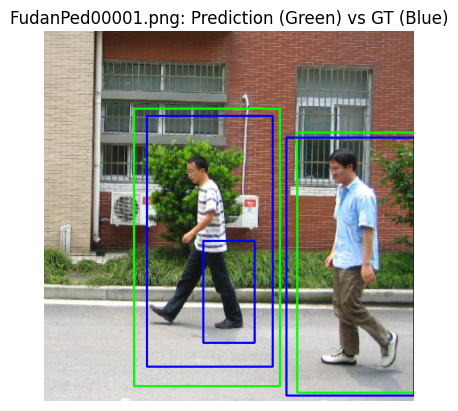

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
FudanPed00002.png - Accuracy: 100.00%


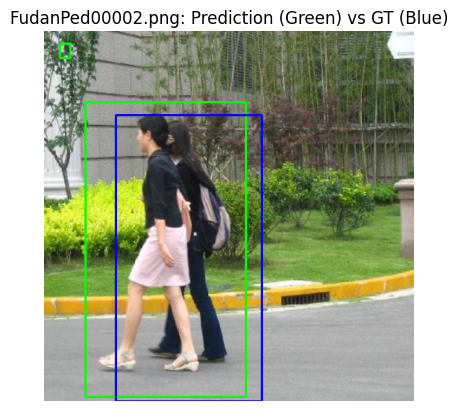

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
FudanPed00003.png - Accuracy: 100.00%


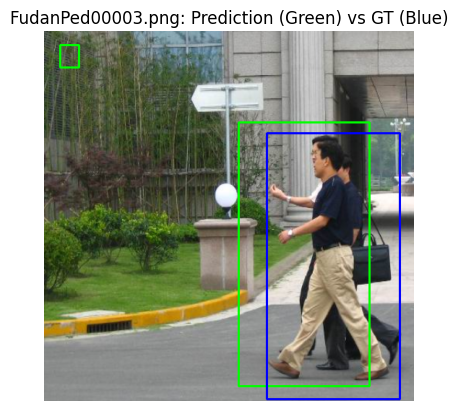

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
FudanPed00004.png - Accuracy: 50.00%


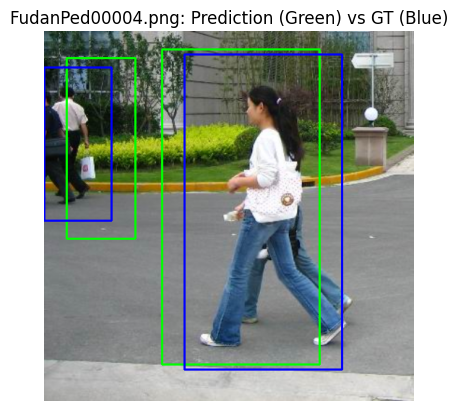

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
FudanPed00005.png - Accuracy: 100.00%


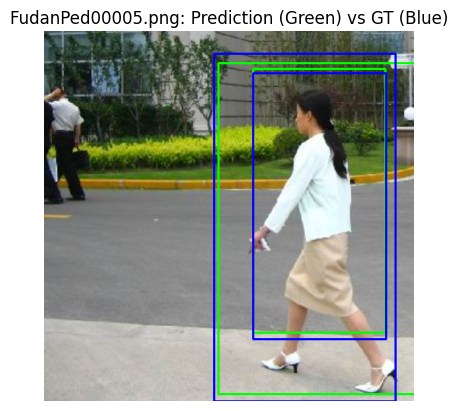

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
FudanPed00006.png - Accuracy: 100.00%


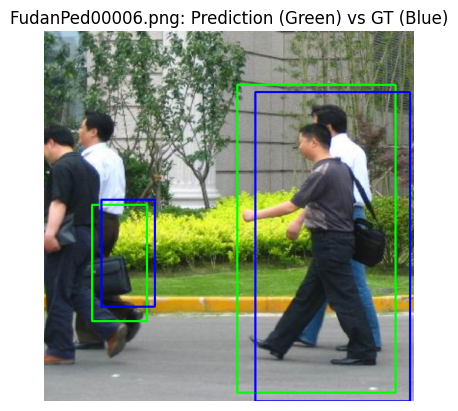

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
FudanPed00007.png - Accuracy: 22.22%


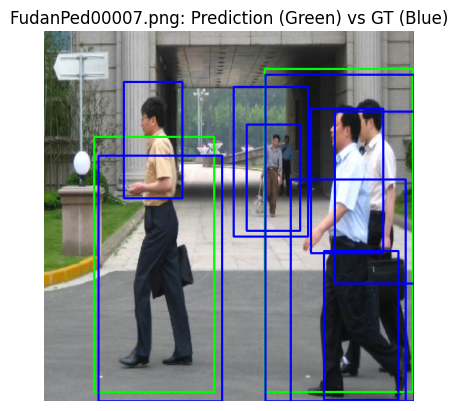

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
FudanPed00008.png - Accuracy: 100.00%


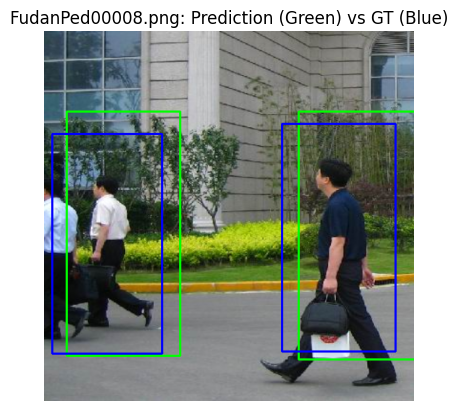

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
FudanPed00009.png - Accuracy: 0.00%


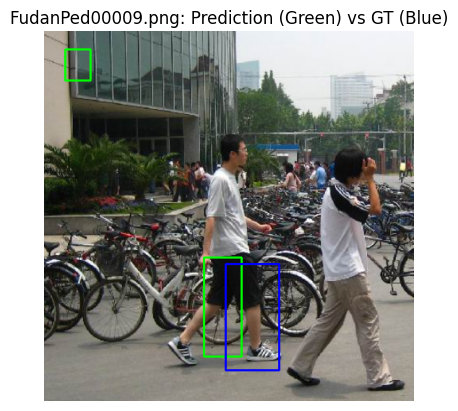

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
FudanPed00010.png - Accuracy: 100.00%


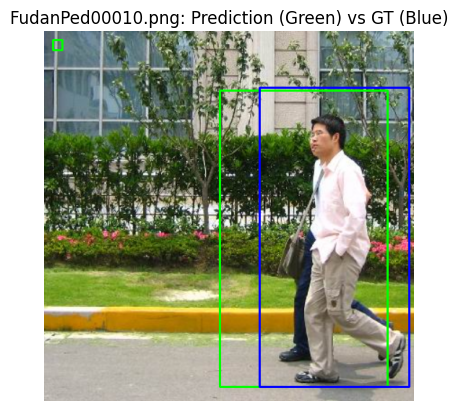


 Final Accuracy on test samples: 58.33%


In [6]:
import os
import json
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

project_dir = r"D:\dl project"
raw_image_dir = os.path.join(project_dir, "PNGImages")
processed_image_dir = os.path.join(project_dir, "Resized_Images")
annotations_path = os.path.join(project_dir, "pedestrian_bboxes.json")

if not os.path.exists(processed_image_dir):
    os.makedirs(processed_image_dir)

original_dim = (512, 512)
resized_dim = (224, 224)
batch_sz = 2

hog_detector = cv2.HOGDescriptor()
hog_detector.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

def extract_pedestrians(img):
    resized = cv2.resize(img, original_dim)
    detections, _ = hog_detector.detectMultiScale(resized, winStride=(4, 4), padding=(8, 8), scale=1.05)
    result_boxes = []
    for (x, y, w, h) in detections:
        result_boxes.append({"x": int(x), "y": int(y), "width": int(w), "height": int(h)})
    return result_boxes

bbox_data = {}
for img_name in os.listdir(raw_image_dir):
    if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
        full_path = os.path.join(raw_image_dir, img_name)
        img = cv2.imread(full_path)
        if img is None:
            continue
        resized_img = cv2.resize(img, original_dim)
        cv2.imwrite(os.path.join(processed_image_dir, img_name), resized_img)
        detected = extract_pedestrians(resized_img)
        bbox_data[img_name] = detected

with open(annotations_path, "w") as f:
    json.dump(bbox_data, f, indent=4)

with open(annotations_path, "r") as f:
    bbox_data = json.load(f)

class CustomDataLoader(Sequence):
    def __init__(self, img_names, annotations, batch_sz):
        self.img_names = img_names
        self.annotations = annotations
        self.batch_sz = batch_sz

    def __len__(self):
        return int(np.ceil(len(self.img_names) / self.batch_sz))

    def __getitem__(self, index):
        batch_imgs = self.img_names[index * self.batch_sz: (index + 1) * self.batch_sz]
        batch_annots = self.annotations[index * self.batch_sz: (index + 1) * self.batch_sz]

        X_batch, y_batch = [], []
        for idx, fname in enumerate(batch_imgs):
            path = os.path.join(processed_image_dir, fname)
            img = cv2.imread(path)
            if img is None:
                continue
            img = cv2.resize(img, resized_dim)
            img = img / 255.0

            annots = batch_annots[idx]
            padded_annots = annots[:2] if len(annots) >= 2 else annots + ([{"x": 0, "y": 0, "width": 0, "height": 0}] * (2 - len(annots)))

            coords = []
            for annot in padded_annots:
                coords.extend([
                    annot["x"] / original_dim[0],
                    annot["y"] / original_dim[1],
                    annot["width"] / original_dim[0],
                    annot["height"] / original_dim[1]
                ])

            X_batch.append(img)
            y_batch.append(coords)

        return np.array(X_batch), np.array(y_batch)

img_files = list(bbox_data.keys())
annot_list = [bbox_data[img] for img in img_files]
train_loader = CustomDataLoader(img_files, annot_list, batch_sz)

pedestrian_model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(8, activation='sigmoid')
])

pedestrian_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])
pedestrian_model.fit(train_loader, epochs=10)
pedestrian_model.save("pedestrian_localizer.h5")
print("✔️ Model trained and saved as pedestrian_localizer.h5!")

def compute_iou(b1, b2):
    x1, y1, w1, h1 = b1
    x2, y2, w2, h2 = b2

    xa1, ya1 = x1, y1
    xa2, ya2 = x1 + w1, y1 + h1
    xb1, yb1 = x2, y2
    xb2, yb2 = x2 + w2, y2 + h2

    xi1, yi1 = max(xa1, xb1), max(ya1, yb1)
    xi2, yi2 = min(xa2, xb2), min(ya2, yb2)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    area1 = w1 * h1
    area2 = w2 * h2
    union_area = area1 + area2 - inter_area

    return inter_area / union_area if union_area else 0.0

correct_preds = 0
total_true_boxes = 0

for idx in range(min(10, len(img_files))):
    file = img_files[idx]
    path = os.path.join(processed_image_dir, file)
    image = cv2.imread(path)
    image_input = cv2.resize(image, resized_dim) / 255.0

    preds = pedestrian_model.predict(np.expand_dims(image_input, axis=0))[0]

    for i in range(2):
        x = int(preds[i * 4 + 0] * original_dim[0])
        y = int(preds[i * 4 + 1] * original_dim[1])
        w = int(preds[i * 4 + 2] * original_dim[0])
        h = int(preds[i * 4 + 3] * original_dim[1])
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    ground_truth = bbox_data[file]
    for gt in ground_truth:
        xa, ya, wa, ha = gt["x"], gt["y"], gt["width"], gt["height"]
        cv2.rectangle(image, (xa, ya), (xa + wa, ya + ha), (255, 0, 0), 2)

    correct = 0
    for i in range(min(2, len(ground_truth))):
        pred_box = [
            int(preds[i * 4 + 0] * original_dim[0]),
            int(preds[i * 4 + 1] * original_dim[1]),
            int(preds[i * 4 + 2] * original_dim[0]),
            int(preds[i * 4 + 3] * original_dim[1])
        ]
        gt_box = [
            ground_truth[i]["x"],
            ground_truth[i]["y"],
            ground_truth[i]["width"],
            ground_truth[i]["height"]
        ]
        iou = compute_iou(pred_box, gt_box)
        if iou >= 0.5:
            correct += 1

    total_true_boxes += len(ground_truth)
    correct_preds += correct

    acc = correct / len(ground_truth) if ground_truth else 0
    print(f"{file} - Accuracy: {acc * 100:.2f}%")

    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"{file}: Prediction (Green) vs GT (Blue)")
    plt.axis('off')
    plt.show()

final_acc = correct_preds / total_true_boxes if total_true_boxes > 0 else 0.0
print(f"\n Final Accuracy on test samples: {final_acc * 100:.2f}%")

In [8]:
pedestrian_model.save("ped_model.h5")